# Курс по машинному обучению,   ВМК МГУ
## Градиентный бустинг деревьев

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на ML-решение**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов




## Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену поддержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**Внимание! Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Установка дополнительных библиотек.

В этом задании нам понадобятся три бибиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

Все библиотеки легко ставятся через pip (либо альтернативные установщики вроде conda).


## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от Вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



**learning_rate** -- темп обучения нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, [1e-3, 1e-2, 1e-1, 1]). В большинстве случаев достаточно перебрать значения от 1e-5 до 1.<br />
**max_depth** -- максимальная глубина деревьев в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека CatBoost, которую мы будем исследовать сегодня, рекомендует перебирать значения до 10 (и уточняется, что обычно оптимальная глубина лежит от 6 до 10).<br />
**n_estimators** -- количество деревьев в ансамбле. Обычно стоит перебирать с каким-то крупным шагом (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно нескольких тысяч деревьев бывает достаточно.<br />

Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если Вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшения рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах: n_estimators=1000, max_depth=5, learning_rate=0.1. Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

<span style="color:red">Загрузите датасет, с которым мы будем работать. Его можно найти на платформе cv-gml.ru, в задании `Град. бустинг (ML)`, по ссылке `Дополнительные файлы для решения`. Если Вы решите сохранить этот файл не рядом с ноутбуком, Вы можете исправить путь к этому файлу во второй ячейке ноутбука (в строке с `read_csv`).</span>

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

In [1]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [2]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1}

df = pd.read_csv('dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


### Задание 0 (без проверки, 0 баллов)

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


In [3]:
df.columns

Index(['Engine Capacity', 'Cylinders', 'Drive Type', 'Fuel Tank Capacity',
       'Fuel Economy', 'Fuel Type', 'Horsepower', 'Torque', 'Transmission',
       'Top Speed', 'Seating Capacity', 'Acceleration', 'Length', 'Width',
       'Height', 'Wheelbase', 'Trunk Capacity', 'name', 'price', 'currency',
       'Country'],
      dtype='object')

In [4]:
(df.currency == df.Country).sum() / len(df.currency)

1.0

Значения столбцов *currency* и *Country* полностью совпадают.

In [5]:
df.groupby('currency').price.median()

currency
0    192500.0
1    174000.0
2    197250.0
3     14950.0
4     21500.0
5     18600.0
Name: price, dtype: float64

<AxesSubplot:title={'center':'price'}, xlabel='currency'>

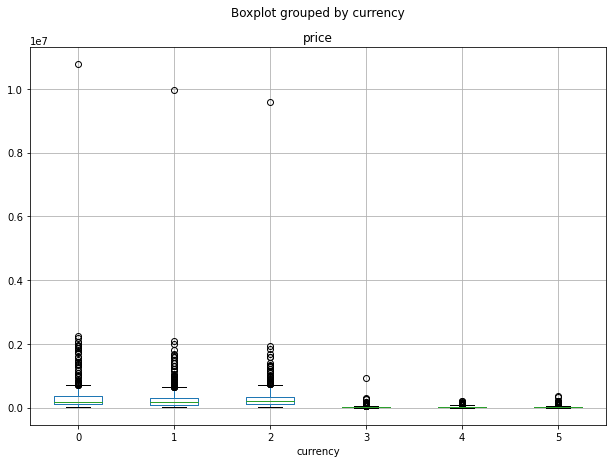

In [6]:
df.boxplot(column='price', by='currency', figsize=(10, 7))

В датафрейме присутствует столбец *currency* - тип валюты, принимающей значения от 0 до 5. Из этого заключаем, что цены представлены в разных валютах, но, по идее, это не должно быть проблемой, т.к. при обучении модель будет использовать признак валюты. (В крайнем случае, можно разделить выборку на 6 классов и обучаться отдельно для каждой)

В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.

### **Задание 1 (кросс-проверка, 3 балла)**
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие пропусков. При необходимости заменить их на среднее значение признака.
3. Добавить столбец brand с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели)
4. Решить, какие признаки Вы хотите сделать категориальными. Конвертировать выбранные категориальные столбцы в тип category. 
5. Создать датасет А с категориальными признаками в виде категорий. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и матрицу признаков с категориальными переменными в виде категорий (получается путем удаления только целевой переменной из матрицы с данными). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать датасет B без категориальных признаков. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей) и удалить из матрицы признаков столбец с целевыми переменными, а также все категориальные переменные.
8. Создать датасет C с категориальными признаками в виде one-hot encoding. Для этого необходимо создать вектор целевых значений (столбец цен автомобилей), удалить из матрицы признаков столбец с целевыми переменными и все категориальными переменные, а затем добавить новые признаки, соответствующие one-hot encoding категориальных переменных (здесь вам поможет функция `pd.get_dummies`).
9. Разбить датасеты на тренировочное и тестовое множества, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

<AxesSubplot:>

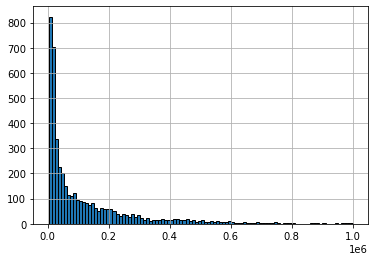

In [7]:
df.price[df.price <= 1e6].hist(bins=100, edgecolor='black')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engine Capacity     4560 non-null   float64
 1   Cylinders           4560 non-null   int64  
 2   Drive Type          4560 non-null   int64  
 3   Fuel Tank Capacity  4560 non-null   float64
 4   Fuel Economy        4560 non-null   float64
 5   Fuel Type           4560 non-null   int64  
 6   Horsepower          4560 non-null   int64  
 7   Torque              4560 non-null   float64
 8   Transmission        4560 non-null   int64  
 9   Top Speed           4560 non-null   int64  
 10  Seating Capacity    4560 non-null   int64  
 11  Acceleration        4560 non-null   float64
 12  Length              4560 non-null   float64
 13  Width               4560 non-null   float64
 14  Height              4560 non-null   float64
 15  Wheelbase           4560 non-null   float64
 16  Trunk 

Пропуски в данных отсутствуют.

Построим гистограммы для числовых признаков, чтобы понять, валидны ли эти значения:

Можно заметить, что значения признаков Width, Height, Length, Wheelbase принимают очень большие значения (порядков нескольких сотен и тысяч), хотя должны иметь смысл линейных размеров автомобиля:

In [9]:
df[(df.Width > 100) | (df.Height > 100) | (df.Length > 100) | (df.Wheelbase > 100)]

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
298,2.0,4,0,69.6,13.8,0,250,377.0,0,200,...,7.5,4795.000,2179.00,1735.000,2850.000,1111.0,Ford Edge 2021 Ambient,159500.0,0,0
348,2.0,4,1,66.0,6.4,0,220,350.0,0,245,...,7.0,4.869,1864.00,1.469,2.841,625.0,Skoda Superb 2021 2.0 TSI Style,118965.0,0,0
349,2.0,4,1,66.0,6.4,0,220,350.0,0,245,...,7.0,4.869,1864.00,1.469,2.841,625.0,Skoda Superb 2021 2.0 TSI Style Plus,138600.0,0,0
856,1.5,4,0,50.0,6.0,0,169,250.0,0,180,...,7.1,4694.000,1848.00,1465.000,2715.000,424.0,MG 6 2021 1.5T STD,59850.0,1,1
886,1.5,4,0,50.0,6.0,0,169,250.0,0,180,...,7.1,4694.000,1848.00,1465.000,2715.000,424.0,MG 6 2021 1.5T LUX,67725.0,1,1
1189,2.0,4,0,69.6,13.8,0,250,377.0,0,200,...,7.5,4795.000,2179.00,1735.000,2850.000,1111.0,Ford Edge 2021 Ambient,142695.0,1,1
1194,2.0,4,1,66.0,7.0,0,268,350.0,0,250,...,5.6,4.869,1864.00,1.469,2.841,625.0,Skoda Superb 2021 2.0 TSI L&K (AWD),143500.0,1,1
2124,2.0,4,0,69.6,13.8,0,250,377.0,0,200,...,7.5,4795.000,2179.00,1735.000,2850.000,1111.0,Ford Edge 2021 Ambient,10000.0,5,5
2151,2.7,4,2,70.0,10.5,0,158,243.0,1,160,...,17.5,5.380,1.88,2.285,3110.000,9800.0,Toyota Hiace 2021 2.7L Panel Van High Roof LWB,10700.0,5,5
2180,2.0,4,1,66.0,7.0,0,268,350.0,0,250,...,5.6,4.869,1864.00,1.469,2.841,625.0,Skoda Superb 2021 2.0 TSI L&K (AWD),11500.0,5,5


Загуглив модели этих автомобилей, можем выяснить, что эти "экстремальные" значения - линейный размеры машины, выраженные в милиметрах (а большинство хначений в метрах). Поэтому необходимо поделить экстремальные значения на 1000:

In [10]:
df.loc[df['Width'] > 100, 'Width'] /= 1000
df.loc[df['Height'] > 100, 'Height'] /= 1000
df.loc[df['Length'] > 100, 'Length'] /= 1000
df.loc[df['Wheelbase'] > 100, 'Wheelbase'] /= 1000

In [11]:
df[(df.Width > 100) | (df.Height > 100) | (df.Length > 100) | (df.Wheelbase > 100)]

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country


Получили адекватные значения для линейных размеров машины.

Добавим столбец *brand* в датафрейм:

In [12]:
df.name.sample(10)

4097                 Renault Koleos 2021 2.5L SE (4WD)
4728                Audi RS7 2021 4.0 TFSI Performance
4963               Toyota Camry 2021 3.5L LTD (298 HP)
3792      Audi Q7 2021 45 TFSI Design quattro (333 HP)
617                        Lexus RX 2021 450h Premier 
1152    Borgward BX7 2021 2.0T AWD Ultimate (7-Seater)
3081               Aston Martin Vanquish 2021 6.0L V12
1197                        Toyota Previa 2021 2.4L SE
1652                        Porsche Panamera 2021 Base
1104                     Peugeot 5008 2021 1.6T Allure
Name: name, dtype: object

In [13]:
df['brand'] = df['name'].apply(lambda s: s.split()[0])

In [14]:
df[['name', 'brand']].sample(5)

,name,brand
362,Chrysler 300S 2021 5.7L V8 Luxury,Chrysler
764,Rolls Royce Ghost 2021 6.6L Short Wheelbase,Rolls
649,Infiniti QX80 2021 5.6L Luxe (7 Seats),Infiniti
2398,Jaguar XE 2021 2.0 Portfolio,Jaguar
2397,Jaguar XE 2021 2.0 Prestige,Jaguar


Категориальные признаки:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Engine Capacity     4560 non-null   float64
 1   Cylinders           4560 non-null   int64  
 2   Drive Type          4560 non-null   int64  
 3   Fuel Tank Capacity  4560 non-null   float64
 4   Fuel Economy        4560 non-null   float64
 5   Fuel Type           4560 non-null   int64  
 6   Horsepower          4560 non-null   int64  
 7   Torque              4560 non-null   float64
 8   Transmission        4560 non-null   int64  
 9   Top Speed           4560 non-null   int64  
 10  Seating Capacity    4560 non-null   int64  
 11  Acceleration        4560 non-null   float64
 12  Length              4560 non-null   float64
 13  Width               4560 non-null   float64
 14  Height              4560 non-null   float64
 15  Wheelbase           4560 non-null   float64
 16  Trunk 

In [16]:
categorical_features = ['Drive Type', 'Fuel Type', 'Transmission', 'currency', 'brand']

In [17]:
for f in categorical_features:
    df[f] = df[f].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5667
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Engine Capacity     4560 non-null   float64 
 1   Cylinders           4560 non-null   int64   
 2   Drive Type          4560 non-null   category
 3   Fuel Tank Capacity  4560 non-null   float64 
 4   Fuel Economy        4560 non-null   float64 
 5   Fuel Type           4560 non-null   category
 6   Horsepower          4560 non-null   int64   
 7   Torque              4560 non-null   float64 
 8   Transmission        4560 non-null   category
 9   Top Speed           4560 non-null   int64   
 10  Seating Capacity    4560 non-null   int64   
 11  Acceleration        4560 non-null   float64 
 12  Length              4560 non-null   float64 
 13  Width               4560 non-null   float64 
 14  Height              4560 non-null   float64 
 15  Wheelbase           4560 non-null   fl

In [18]:
df.select_dtypes(exclude=['category', 'object']).columns

Index(['Engine Capacity', 'Cylinders', 'Fuel Tank Capacity', 'Fuel Economy',
       'Horsepower', 'Torque', 'Top Speed', 'Seating Capacity', 'Acceleration',
       'Length', 'Width', 'Height', 'Wheelbase', 'Trunk Capacity', 'price',
       'Country'],
      dtype='object')

In [20]:
datasets = {'A' : None, 'B': None, 'C': None}

# your awesome code here

Y = df['price']
X = {'A' : None, 'B' : None, 'C' : None}

X['A'] = df.drop(columns=['price']).select_dtypes(['category'])
X['B'] = df.drop(columns=['price', 'Wheelbase']).select_dtypes(exclude=['category', 'object'])
X['C'] = pd.get_dummies(X['A'])

for key in datasets.keys():
    datasets[key] = train_test_split(X[key], Y, test_size=0.25, random_state=0)

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

## Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, поскольку в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

FYI: в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.

### **Задание 2 (кросс-проверка, 2 балла)**:

**Данные**: датасет со стоимостью поддержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить sklearn.ensemble.GradientBoostingRegressor на датасете B (можно и на C, если позволяют вычислительные ресурсы), используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth. для простоты можете воспользоваться GridSearchCV. При необходимости можно оптимизировать параметры по одному, а не все сразу. Выведите лучшие параметры. Получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. Для ускорения процесса не забудьте воспользоваться n_jobs.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
5. Вывести результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?


In [21]:
df_skl = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'Train_MAE', 'Test_MAE'])

### Датасет B

#### Обучение с дефолтными параметрами 

#### Оптимизация параметров по сетке

### Датасет C

#### Обучение с дефолтными параметрами

#### Оптимизация параметров по сетке

**Ваши выводы:** обучается супердолго, мне тупо не хватило терпения...

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако, для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется xgboost.

## Градиентный бустинг с XGBoost

XGBoost стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая. Хорошая – xgboost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn и даже прекрасно работает с GridSearchCV. Плохая – она тоже не умеет из коробки работать с категориальными признаками. Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс xgboost.XGBRegressor.

Update: относительно недавно в xgboost появилась экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться пока не будем.

### Задание 3 (кросс-проверка, 2 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на датасетах B и C, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерьте время обучения. Получите предсказания данных моделей на тестовом множестве.
2. Обучить xgboost.XGBRegressor на датасетах B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). При необходимости можно оптимизировать параметры по одному, а не все сразу. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве. В этом случае устанавливать n_jobs у GridSearchCV не рекомендую, поскольку xgboost сам умеет захватывать все доступные ресурсы, и если GridSearchCV начнет их размножать, то последствия будут печальны.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
1. Выведите результаты и время в таблице DataFrame.
4. Сделайте выводы. Оцените полезность категориальных переменных и поиска оптимальных параметров. Оцените время, затраченное на обучение. Сравните результаты со sklearn.

In [130]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'Train_MAE', 'Test_MAE'])

### Датасет B

#### Обучение с дефолтными параметрами

In [131]:
%%time

X_train, X_test, y_train, y_test = datasets['B']

xgb = XGBRegressor(**test_parameters, eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

start = time.time()
xgb.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, xgb.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_xgb = pd.concat([df_xgb, res], ignore_index=True)
df_xgb

Wall time: 1.38 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.341923,92327.374768,123173.275571


#### Оптимизация параметров по сетке

In [132]:
%%time

parameters = {
    'n_estimators' : [1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(3, 10, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['B']

model = XGBRegressor(eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3, verbose=3)

start = time.time()
grid_search.fit(X_train, y_train)
learning_time = time.time() - start

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-126242.637 total time=   0.7s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-121357.763 total time=   0.6s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-137427.494 total time=   0.7s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-124837.634 total time=   1.3s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-128072.684 total time=   2.3s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-137981.549 total time=   2.3s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-124137.224 total time=   3.6s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-130775.438 total time=   3.3s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-137505.375 total time=   3.6s
[C

[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=3000;, score=-132124.147 total time=   7.0s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=3000;, score=-138802.497 total time=   7.0s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-119016.320 total time=  11.9s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-132804.337 total time=  11.8s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-139288.517 total time=  11.9s
[CV 1/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-118097.727 total time=   3.2s
[CV 2/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-131495.294 total time=   3.1s
[CV 3/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-138041.583 total time=   3.0s
[CV 1/3] END learning_rate=0.01, max_depth=9, n_estimators=2000;, score=-118299.405 total time=   6.5s
[CV 2/3] END learning_rate=0.01, max_depth=9, n_estimators=2000;, score=-

[CV 2/3] END learning_rate=1, max_depth=5, n_estimators=2000;, score=-135807.261 total time=   3.3s
[CV 3/3] END learning_rate=1, max_depth=5, n_estimators=2000;, score=-140427.513 total time=   3.3s
[CV 1/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-119402.802 total time=   4.7s
[CV 2/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-135807.264 total time=   4.2s
[CV 3/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-140427.513 total time=   4.5s
[CV 1/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-119402.802 total time=   7.3s
[CV 2/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-135807.269 total time=   7.0s
[CV 3/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-140427.512 total time=   7.4s
[CV 1/3] END learning_rate=1, max_depth=7, n_estimators=1000;, score=-120300.509 total time=   2.0s
[CV 2/3] END learning_rate=1, max_depth=7, n_estimators=1000;, score=-136124.467 total time=   1.9s


In [133]:
grid_search.best_params_

{'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 1000}

In [134]:
xgb = XGBRegressor(**grid_search.best_params_, eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

xgb.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, xgb.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['best_by_grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_xgb = pd.concat([df_xgb, res], ignore_index=True)
df_xgb

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.341923,92327.374768,123173.275571
1,B,best_by_grid_search,1075.203489,114271.369703,118045.756325


### Датасет С

#### Обучение с дефолтными параметрами

In [136]:
%%time

X_train, X_test, y_train, y_test = datasets['C']

xgb = XGBRegressor(**test_parameters, eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

start = time.time()
xgb.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, xgb.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb.predict(X_test))

res = pd.DataFrame({'Dataset' : ['С'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_xgb = pd.concat([df_xgb, res], ignore_index=True)
df_xgb

Wall time: 2.33 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.341923,92327.374768,123173.275571
1,B,best_by_grid_search,1075.203489,114271.369703,118045.756325
2,С,default,2.305092,32892.740846,40524.790207


#### Оптимизация параметров по сетке 

In [139]:
%%time

parameters = {
    'n_estimators' : [1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(3, 10, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['C']

model = XGBRegressor(eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3, verbose=3)

start = time.time()
grid_search.fit(X_train, y_train)
learning_time = time.time() - start

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-105434.429 total time=   1.3s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-102913.894 total time=   1.3s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1000;, score=-122440.351 total time=   1.2s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-93444.723 total time=   2.5s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-100919.830 total time=   2.7s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=2000;, score=-114810.931 total time=   4.5s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-87739.918 total time=   6.6s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-97429.249 total time=   6.4s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=3000;, score=-110847.100 total time=   6.5s
[CV 1

[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=3000;, score=-59001.339 total time=  10.8s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-42845.742 total time=  18.3s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-49891.790 total time=  17.9s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=5000;, score=-57680.661 total time=  18.2s
[CV 1/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-44086.209 total time=   4.4s
[CV 2/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-50266.732 total time=   4.5s
[CV 3/3] END learning_rate=0.01, max_depth=9, n_estimators=1000;, score=-60142.246 total time=   5.1s
[CV 1/3] END learning_rate=0.01, max_depth=9, n_estimators=2000;, score=-42834.937 total time=  12.5s
[CV 2/3] END learning_rate=0.01, max_depth=9, n_estimators=2000;, score=-49803.875 total time=  14.0s
[CV 3/3] END learning_rate=0.01, max_depth=9, n_estimators=2000;, score=-58202.919

[CV 1/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-42244.063 total time=  12.3s
[CV 2/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-48739.059 total time=  12.2s
[CV 3/3] END learning_rate=1, max_depth=5, n_estimators=3000;, score=-57435.707 total time=  12.3s
[CV 1/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-42244.063 total time=  19.9s
[CV 2/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-48739.060 total time=  19.7s
[CV 3/3] END learning_rate=1, max_depth=5, n_estimators=5000;, score=-57435.707 total time=  21.2s
[CV 1/3] END learning_rate=1, max_depth=7, n_estimators=1000;, score=-42661.606 total time=   5.6s
[CV 2/3] END learning_rate=1, max_depth=7, n_estimators=1000;, score=-49895.350 total time=   5.4s
[CV 3/3] END learning_rate=1, max_depth=7, n_estimators=1000;, score=-58250.464 total time=   5.9s
[CV 1/3] END learning_rate=1, max_depth=7, n_estimators=2000;, score=-42661.606 total time=  10.7s
[CV 2/3] E

In [140]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}

In [141]:
xgb = XGBRegressor(**grid_search.best_params_, eval_metric='mae', booster='gbtree', n_jobs=-1, verbosity=1, random_state=111)

xgb.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, xgb.predict(X_train))
test_mae = mean_absolute_error(y_test, xgb.predict(X_test))

res = pd.DataFrame({'Dataset' : ['C'], 
                    'Parameters' : ['best_by_grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_xgb = pd.concat([df_xgb, res], ignore_index=True)
df_xgb

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.341923,92327.374768,123173.275571
1,B,best_by_grid_search,1075.203489,114271.369703,118045.756325
2,С,default,2.305092,32892.740846,40524.790207
3,C,best_by_grid_search,1960.140759,31410.232404,39661.632418


**Ваши выводы:**  
В случае датасета В можно наблюдать большую разницу между ошибкой на обучении (92000) и ошибкой на тесте (123000), что видимо говорит о переобученности модели. При оптимизации параметров по сетке получилось достичь сопоставимых ошибок на трэйне и тесте, причем ошибка на тесте меньше, чем с дефолтными параметрами. Перебор по всей сетке параметров занял довольно много времени (около 18 минут).   
При обучении на датасете С с дефолтными параметрами получили ошибку на тесте порядка 40000, что намного лучше, чем на датасете В. Это говорит о бОльшей полезности категориальных признаков, чем числовых. При оптимизации параметров по сетке удалось уменьшить ошибку на тесте примерно на 1000. При этом перебор параметров по сетке занял намного больше времени, т.к. к категориальным признакам применялось one-hot-encoding, из-за чего количество признаков сильно увеличилось.

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она lightgbm.

## Градиентный бустинг в lightgbm

Про Lightgbm легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих. Первая хорошая — lightgbm тоже работает с GridSearchCV. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками! Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться.

Внимание! LightGBM может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)

### Задание 4 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненном в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для датасета A. Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
3. Обучить lightgbm.LGBMRegressor на датасетах A, B и C, используя кросс-валидацию на тренировочном множестве и подбирая значения для параметров n_estimators, learning_rate и max_depth (для простоты можете воспользоваться GridSearchCV). Замерьте время, потраченное на поиск оптимальных параметров(вновь не советую использовать n_jobs). Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
4. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.

In [26]:
import warnings
warnings.filterwarnings("ignore")

df_lightgbm = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'Train_MAE', 'Test_MAE'])

# your great code here

### Датасет В

#### Обучение с дефолтными параметрами

In [27]:
%%time

X_train, X_test, y_train, y_test = datasets['B']

lgbm = LGBMRegressor(**test_parameters, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

start = time.time()
lgbm.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

Wall time: 373 ms


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781


#### Оптимизация параметров по сетке

In [42]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000, 6000],
    'max_depth' : [i for i in range(6, 13, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['B']

model = LGBMRegressor(**parameters, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3, verbose=3)

start = time.time()
grid_search.fit(X_train, y_train)
learning_time = time.time() - start

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-128455.936 total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-111059.121 total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-140369.593 total time=   0.1s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-126894.451 total time=   0.4s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-110964.686 total time=   0.4s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-139280.115 total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-125341.774 total time=   0.9s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-111882.043 total time=   0.9s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-138716.840 total time=   0.7s
[CV 1

[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=2000;, score=-121259.412 total time=   1.4s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=2000;, score=-136469.552 total time=   1.1s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=3000;, score=-124038.353 total time=   2.0s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=3000;, score=-121920.121 total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=3000;, score=-136586.197 total time=   1.6s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=5000;, score=-124142.047 total time=   3.5s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=5000;, score=-122502.750 total time=   3.4s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=5000;, score=-136921.449 total time=   2.7s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=6000;, score=-124323.525 total time=   4.7s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=6000;, score=-

[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=6000;, score=-124590.592 total time=   3.6s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=6000;, score=-125918.787 total time=   3.7s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=6000;, score=-139535.978 total time=   3.4s
[CV 1/3] END learning_rate=0.1, max_depth=8, n_estimators=500;, score=-123987.997 total time=   0.5s
[CV 2/3] END learning_rate=0.1, max_depth=8, n_estimators=500;, score=-123306.063 total time=   0.4s
[CV 3/3] END learning_rate=0.1, max_depth=8, n_estimators=500;, score=-140065.040 total time=   0.3s
[CV 1/3] END learning_rate=0.1, max_depth=8, n_estimators=1000;, score=-123825.911 total time=   0.8s
[CV 2/3] END learning_rate=0.1, max_depth=8, n_estimators=1000;, score=-124841.153 total time=   0.8s
[CV 3/3] END learning_rate=0.1, max_depth=8, n_estimators=1000;, score=-141002.145 total time=   0.7s
[CV 1/3] END learning_rate=0.1, max_depth=8, n_estimators=2000;, score=-123853.997 to

[CV 1/3] END learning_rate=1, max_depth=8, n_estimators=2000;, score=-129023.425 total time=   2.3s
[CV 2/3] END learning_rate=1, max_depth=8, n_estimators=2000;, score=-132251.319 total time=   2.2s
[CV 3/3] END learning_rate=1, max_depth=8, n_estimators=2000;, score=-147855.108 total time=   2.1s
[CV 1/3] END learning_rate=1, max_depth=8, n_estimators=3000;, score=-129064.151 total time=   3.5s
[CV 2/3] END learning_rate=1, max_depth=8, n_estimators=3000;, score=-133557.738 total time=   3.5s
[CV 3/3] END learning_rate=1, max_depth=8, n_estimators=3000;, score=-148069.255 total time=   3.3s
[CV 1/3] END learning_rate=1, max_depth=8, n_estimators=5000;, score=-128892.551 total time=   5.8s
[CV 2/3] END learning_rate=1, max_depth=8, n_estimators=5000;, score=-134218.451 total time=   5.9s
[CV 3/3] END learning_rate=1, max_depth=8, n_estimators=5000;, score=-148122.814 total time=   5.6s
[CV 1/3] END learning_rate=1, max_depth=8, n_estimators=6000;, score=-128859.647 total time=   6.9s


In [43]:
grid_search.best_score_, grid_search.best_params_

(-124746.79595238867,
 {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 2000})

In [44]:
%%time

X_train, X_test, y_train, y_test = datasets['B']

lgbm = LGBMRegressor(**grid_search.best_params_, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

lgbm.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 2.54 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,grid_search,853.286257,113013.607794,115965.723649


In [45]:
df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781
1,B,grid_search,853.286257,113013.607794,115965.723649


### Датасет С

#### Обучение с дефолтными параметрами

In [49]:
%%time

X_train, X_test, y_train, y_test = datasets['C']

lgbm = LGBMRegressor(**test_parameters, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

start = time.time()
lgbm.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['C'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

Wall time: 318 ms


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781
1,B,grid_search,853.286257,113013.607794,115965.723649
2,C,default,0.272631,59254.587516,51602.442228


#### Оптимизация параметров по сетке

In [52]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(6, 13, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['C']

model = LGBMRegressor(**parameters, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3, verbose=3)

start = time.time()
grid_search.fit(X_train, y_train)
learning_time = time.time() - start

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-101187.028 total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-86108.696 total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-115873.777 total time=   0.1s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-86517.267 total time=   0.2s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-72027.445 total time=   0.3s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-102484.332 total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-75119.997 total time=   0.6s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-61490.318 total time=   0.5s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-92244.672 total time=   0.6s
[CV 1/3] EN

[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=1000;, score=-49583.445 total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=1000;, score=-82598.924 total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-64355.046 total time=   0.9s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-47807.267 total time=   1.1s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-82036.557 total time=   1.1s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-64033.201 total time=   1.6s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-47259.097 total time=   1.6s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-81619.626 total time=   1.5s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=5000;, score=-62983.064 total time=   2.3s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=5000;, score=-46675.997

[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=-43789.519 total time=   1.6s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=-75059.873 total time=   1.7s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-59944.093 total time=   2.4s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-43676.702 total time=   2.8s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-74716.176 total time=   2.9s
[CV 1/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-60217.307 total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-45969.266 total time=   0.3s
[CV 3/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-77633.911 total time=   0.3s
[CV 1/3] END learning_rate=0.1, max_depth=12, n_estimators=1000;, score=-59511.357 total time=   0.6s
[CV 2/3] END learning_rate=0.1, max_depth=12, n_estimators=1000;, score=-45825.573 to

In [53]:
grid_search.best_score_, grid_search.best_params_

(-57867.25810341312,
 {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 5000})

In [54]:
%%time

X_train, X_test, y_train, y_test = datasets['C']

lgbm = LGBMRegressor(**grid_search.best_params_, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

lgbm.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['C'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 3.09 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,C,grid_search,340.791159,45094.72197,41274.279595


In [55]:
df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781
1,B,grid_search,853.286257,113013.607794,115965.723649
2,C,default,0.272631,59254.587516,51602.442228
3,C,grid_search,340.791159,45094.721970,41274.279595


### Датасет А

#### Обучение с дефолтными параметрами

In [56]:
%%time

X_train, X_test, y_train, y_test = datasets['A']

lgbm = LGBMRegressor(**test_parameters, objective='mae', 
                     boosting_type='gbdt', categorical_feature='auto',
                     n_jobs=-1, random_state=111)

start = time.time()
lgbm.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['A'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

Wall time: 436 ms


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781
1,B,grid_search,853.286257,113013.607794,115965.723649
2,C,default,0.272631,59254.587516,51602.442228
3,C,grid_search,340.791159,45094.721970,41274.279595
4,A,default,0.355461,45382.371815,40271.094384


#### Оптимизация параметров по сетке

In [57]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(6, 13, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['A']

model = LGBMRegressor(**parameters, objective='mae', 
                      boosting_type='gbdt', categorical_feature='auto',
                      n_jobs=-1, random_state=111)

grid_search = GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3, verbose=3)

start = time.time()
grid_search.fit(X_train, y_train)
learning_time = time.time() - start

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-98823.516 total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-84594.140 total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=500;, score=-114138.195 total time=   0.1s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-78580.232 total time=   0.3s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-66368.347 total time=   0.3s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000;, score=-95809.772 total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-63662.946 total time=   0.7s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-51191.869 total time=   0.8s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=2000;, score=-83075.740 total time=   0.9s
[CV 1/3] END 

[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=1000;, score=-44830.857 total time=   0.8s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=1000;, score=-73823.060 total time=   0.8s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-53443.813 total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-43277.288 total time=   1.7s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=2000;, score=-71727.842 total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-52843.974 total time=   2.7s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-42585.174 total time=   2.7s
[CV 3/3] END learning_rate=0.01, max_depth=8, n_estimators=3000;, score=-70580.350 total time=   2.6s
[CV 1/3] END learning_rate=0.01, max_depth=8, n_estimators=5000;, score=-52050.930 total time=   5.0s
[CV 2/3] END learning_rate=0.01, max_depth=8, n_estimators=5000;, score=-41554.945

[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=-39022.264 total time=   3.5s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=-64208.219 total time=   3.3s
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-51669.217 total time=   7.1s
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-39038.073 total time=   6.6s
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=-63889.897 total time=   6.4s
[CV 1/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-54333.869 total time=   0.7s
[CV 2/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-40970.920 total time=   0.4s
[CV 3/3] END learning_rate=0.1, max_depth=12, n_estimators=500;, score=-67619.116 total time=   0.5s
[CV 1/3] END learning_rate=0.1, max_depth=12, n_estimators=1000;, score=-53673.223 total time=   1.2s
[CV 2/3] END learning_rate=0.1, max_depth=12, n_estimators=1000;, score=-39562.900 to

In [58]:
grid_search.best_score_, grid_search.best_params_

(-51416.34646124641,
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 5000})

In [59]:
%%time

X_train, X_test, y_train, y_test = datasets['A']

lgbm = LGBMRegressor(**grid_search.best_params_, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

lgbm.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['A'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 3.19 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,A,grid_search,542.545419,43208.67685,39563.321249


In [60]:
df_lightgbm = pd.concat([df_lightgbm, res], ignore_index=True)
df_lightgbm

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,0.323219,96244.168095,121169.763781
1,B,grid_search,853.286257,113013.607794,115965.723649
2,C,default,0.272631,59254.587516,51602.442228
3,C,grid_search,340.791159,45094.721970,41274.279595
4,A,default,0.355461,45382.371815,40271.094384
5,A,grid_search,542.545419,43208.676850,39563.321249


**Ваши выводы:**   
*Датасет В:* снова наблюдаем переобучение с дефолтными параметрами - ошибка на обучении отличается от ошибки на тесте на 25000.
Оптимизация параметров по сетке дала результат лучше в сравнении с XGB и по времени обучения, и по ошибке на тесте.  
*Датасет С:* оптимизация параметров дала солидное уменьшение ошибки на тесте, при этом перебор занял не больше 6 минут, так что в данном случае перебор оказался очень полезным.  
*Датасет А:* оптимизация параметров по сетке заняла не больше 10 минут, ошибка на тесте не сильно уменьшилась. Перебор по той же сетке параметров, что и для датасета С, занял больше времени примерно в полтора раза.

Как вы видите, иногда можно не возиться с OHE, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека съела данные).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.



## Градиентный бустинг в catboost

Библиотека, созданная в тёмных подвалах яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим.
Вас, наверное, не удивить тем, что эта библиотека работает с GridSearchCV, но им мы пользоваться не будем. В catboost существует своя реализация перебора параметров, и мы попробуем им воспользоваться (ура, разнообразие!). В качестве регрессора нас интересует catboost.CatBoostRegressor.

Внимание! Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. К сожалению, отключением warnings её не сделать молчаливее. А еще эта библиотека может неожиданно создать вам парочку новых папок.

### Задание 5 (кросс-проверка, 3 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения, получите предсказания данных моделей на тестовом множестве.
2. Обучить catboost.CatBoostRegressor на датасетах A, B и C, используя метод grid_search (является методом экземпляра класса CatBoostRegressor). Замерьте время, потраченное на поиск оптимальных параметров. Замерьте время перебора, получите предсказания лучшей модели (с лучшими параметрами) на тестовом множестве.
3. Посчитать MAE для полученных предсказаний на тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. Сделайте выводы и полезности использования категориальных переменных и поиска оптимальных параметров.
5. Вывести результаты и время в таблице DataFrame.


In [63]:
df_catboost = pd.DataFrame(columns=['Dataset', 'Parameters', 'Time', 'Train_MAE', 'Test_MAE'])

# your ideal code here

### Датасет В

#### Обучение с дефолтными параметрами

In [64]:
%%time

X_train, X_test, y_train, y_test = datasets['B']

catboost = CatBoostRegressor(**test_parameters, loss_function='MAE', random_state=111, verbose=0, thread_count=-1)

start = time.time()
catboost.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

Wall time: 1.53 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419


#### Оптимизация параметров по сетке

In [69]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(3, 11, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['B']

model = CatBoostRegressor(loss_function='MAE', random_state=111, verbose=0, thread_count=None)

start = time.time()
grid_search_result = model.grid_search(parameters, X_train, y_train, cv=3)
learning_time = time.time() - start

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


bestTest = 128676.0583
bestIteration = 499

0:	loss: 128676.0582530	best: 128676.0582530 (0)	total: 576ms	remaining: 45.5s

bestTest = 51212.19994
bestIteration = 499

1:	loss: 51212.1999384	best: 51212.1999384 (1)	total: 1.25s	remaining: 48.7s

bestTest = 33234.63051
bestIteration = 499

2:	loss: 33234.6305136	best: 33234.6305136 (2)	total: 1.86s	remaining: 47.7s

bestTest = 32672.95794
bestIteration = 192

3:	loss: 32672.9579363	best: 32672.9579363 (3)	total: 2.4s	remaining: 45.6s

bestTest = 98255.68725
bestIteration = 999

4:	loss: 98255.6872514	best: 32672.9579363 (3)	total: 3.58s	remaining: 53.7s

bestTest = 45036.02936
bestIteration = 999

5:	loss: 45036.0293576	best: 32672.9579363 (3)	total: 4.78s	remaining: 59s

bestTest = 27626.05111
bestIteration = 999

6:	loss: 27626.0511132	best: 27626.0511132 (6)	total: 6.01s	remaining: 1m 2s

bestTest = 32672.95794
bestIteration = 192

7:	loss: 32672.9579363	best: 27626.0511132 (6)	total: 7.29s	remaining: 1m 5s

bestTest = 70265.26633
b


bestTest = 23243.3203
bestIteration = 977

66:	loss: 23243.3203033	best: 19690.4999249 (58)	total: 7m 24s	remaining: 1m 26s

bestTest = 36212.13887
bestIteration = 140

67:	loss: 36212.1388688	best: 19690.4999249 (58)	total: 7m 35s	remaining: 1m 20s

bestTest = 52473.93865
bestIteration = 1999

68:	loss: 52473.9386508	best: 19690.4999249 (58)	total: 7m 57s	remaining: 1m 16s

bestTest = 21048.02564
bestIteration = 1997

69:	loss: 21048.0256437	best: 19690.4999249 (58)	total: 8m 23s	remaining: 1m 11s

bestTest = 22982.60628
bestIteration = 1815

70:	loss: 22982.6062845	best: 19690.4999249 (58)	total: 8m 54s	remaining: 1m 7s

bestTest = 36212.13887
bestIteration = 140

71:	loss: 36212.1388688	best: 19690.4999249 (58)	total: 9m 25s	remaining: 1m 2s

bestTest = 40294.34426
bestIteration = 2999

72:	loss: 40294.3442600	best: 19690.4999249 (58)	total: 10m 10s	remaining: 58.6s

bestTest = 20218.00175
bestIteration = 2999

73:	loss: 20218.0017529	best: 19690.4999249 (58)	total: 10m 57s	remaini

In [77]:
grid_search_result['params']

{'depth': 9, 'iterations': 5000, 'learning_rate': 0.01}

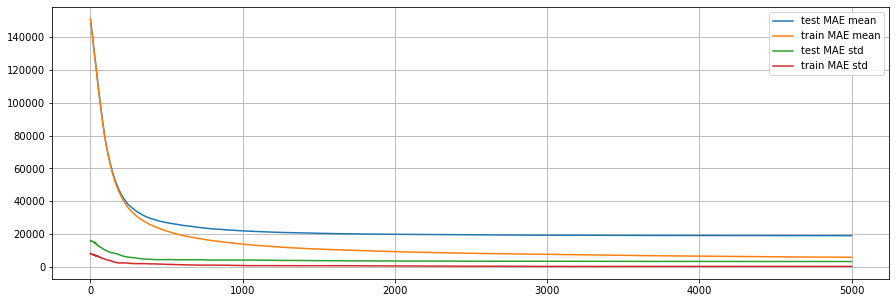

In [87]:
cv_res = grid_search_result['cv_results']

plt.figure(figsize=(15, 5))

plt.plot(cv_res['iterations'], cv_res['test-MAE-mean'], label='test MAE mean')
plt.plot(cv_res['iterations'], cv_res['train-MAE-mean'], label='train MAE mean')

plt.plot(cv_res['iterations'], cv_res['test-MAE-std'], label='test MAE std')
plt.plot(cv_res['iterations'], cv_res['train-MAE-std'], label='train MAE std')

plt.legend()
plt.grid()
plt.show()

In [88]:
%%time

X_train, X_test, y_train, y_test = datasets['B']

catboost = CatBoostRegressor(**grid_search_result['params'], loss_function='MAE', random_state=111, verbose=0)

catboost.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['B'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 51.6 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,grid_search,1296.603924,6401.881716,15206.20319


In [89]:
df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419
1,B,grid_search,1296.603924,6401.881716,15206.203190


### Датасет С

#### Обучение с дефолтными параметрами

In [91]:
%%time

X_train, X_test, y_train, y_test = datasets['C']

catboost = CatBoostRegressor(**test_parameters, loss_function='MAE', random_state=111, verbose=0, thread_count=-1)

start = time.time()
catboost.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['C'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

Wall time: 1.37 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419
1,B,grid_search,1296.603924,6401.881716,15206.203190
2,C,default,1.349251,35147.434687,40415.019178


#### Оптимизация параметров по сетке

In [92]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(3, 11, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['C']

model = CatBoostRegressor(loss_function='MAE', random_state=111, verbose=0, thread_count=None)

start = time.time()
grid_search_result = model.grid_search(parameters, X_train, y_train, cv=3)
learning_time = time.time() - start


bestTest = 134220.6374
bestIteration = 499

0:	loss: 134220.6373783	best: 134220.6373783 (0)	total: 615ms	remaining: 48.6s

bestTest = 88562.73107
bestIteration = 499

1:	loss: 88562.7310737	best: 88562.7310737 (1)	total: 1.31s	remaining: 51.3s

bestTest = 70625.95649
bestIteration = 499

2:	loss: 70625.9564893	best: 70625.9564893 (2)	total: 1.99s	remaining: 51.1s

bestTest = 45871.79974
bestIteration = 355

3:	loss: 45871.7997428	best: 45871.7997428 (3)	total: 2.64s	remaining: 50.1s

bestTest = 112814.3355
bestIteration = 999

4:	loss: 112814.3355226	best: 45871.7997428 (3)	total: 3.95s	remaining: 59.2s

bestTest = 82900.61758
bestIteration = 999

5:	loss: 82900.6175755	best: 45871.7997428 (3)	total: 5.24s	remaining: 1m 4s

bestTest = 59056.15578
bestIteration = 997

6:	loss: 59056.1557840	best: 45871.7997428 (3)	total: 6.61s	remaining: 1m 8s

bestTest = 45871.79974
bestIteration = 355

7:	loss: 45871.7997428	best: 45871.7997428 (3)	total: 7.87s	remaining: 1m 10s

bestTest = 98754.34


bestTest = 45192.67208
bestIteration = 886

66:	loss: 45192.6720753	best: 39223.8347943 (63)	total: 8m 24s	remaining: 1m 37s

bestTest = 39223.83479
bestIteration = 72

67:	loss: 39223.8347943	best: 39223.8347943 (63)	total: 8m 33s	remaining: 1m 30s

bestTest = 87547.92344
bestIteration = 1999

68:	loss: 87547.9234419	best: 39223.8347943 (63)	total: 8m 48s	remaining: 1m 24s

bestTest = 53979.03275
bestIteration = 1999

69:	loss: 53979.0327492	best: 39223.8347943 (63)	total: 9m 7s	remaining: 1m 18s

bestTest = 45115.04671
bestIteration = 1038

70:	loss: 45115.0467091	best: 39223.8347943 (63)	total: 9m 25s	remaining: 1m 11s

bestTest = 39223.83479
bestIteration = 72

71:	loss: 39223.8347943	best: 39223.8347943 (63)	total: 9m 45s	remaining: 1m 5s

bestTest = 78926.13672
bestIteration = 2999

72:	loss: 78926.1367172	best: 39223.8347943 (63)	total: 10m 9s	remaining: 58.4s

bestTest = 48916.95126
bestIteration = 2997

73:	loss: 48916.9512595	best: 39223.8347943 (63)	total: 10m 36s	remaining

In [94]:
grid_search_result['params']

{'depth': 9, 'learning_rate': 1, 'iterations': 500}

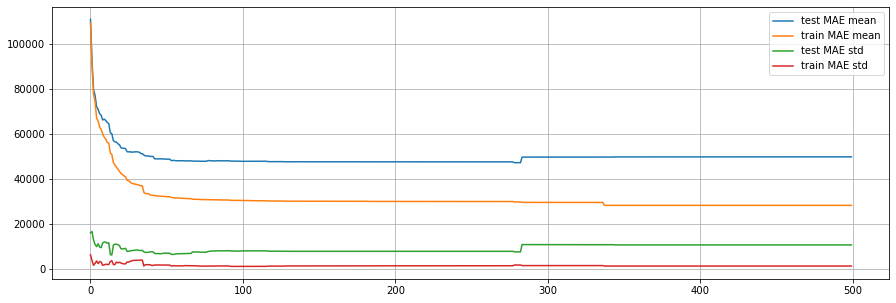

In [95]:
cv_res = grid_search_result['cv_results']

plt.figure(figsize=(15, 5))

plt.plot(cv_res['iterations'], cv_res['test-MAE-mean'], label='test MAE mean')
plt.plot(cv_res['iterations'], cv_res['train-MAE-mean'], label='train MAE mean')

plt.plot(cv_res['iterations'], cv_res['test-MAE-std'], label='test MAE std')
plt.plot(cv_res['iterations'], cv_res['train-MAE-std'], label='train MAE std')

plt.legend()
plt.grid()
plt.show()

In [99]:
%%time

X_train, X_test, y_train, y_test = datasets['C']

catboost = CatBoostRegressor(**grid_search_result['params'], loss_function='MAE', random_state=111, verbose=0)

catboost.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['C'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 2.95 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,C,grid_search,887.521134,29547.976901,41243.672807


In [100]:
df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419
1,B,grid_search,1296.603924,6401.881716,15206.203190
2,C,default,1.349251,35147.434687,40415.019178
3,C,grid_search,887.521134,29547.976901,41243.672807


### Датасет А

In [102]:
categorical_features = list(datasets['A'][0].columns)
categorical_features

['Drive Type', 'Fuel Type', 'Transmission', 'currency', 'brand']

#### Обучение с дефолтными параметрами

In [103]:
%%time

X_train, X_test, y_train, y_test = datasets['A']

catboost = CatBoostRegressor(**test_parameters, loss_function='MAE', cat_features=categorical_features, 
                             random_state=111, verbose=0, thread_count=-1)

start = time.time()
catboost.fit(X_train, y_train)
learning_time = time.time() - start

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['A'], 
                    'Parameters' : ['default'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })

df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

Wall time: 18.2 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419
1,B,grid_search,1296.603924,6401.881716,15206.203190
2,C,default,1.349251,35147.434687,40415.019178
3,C,grid_search,887.521134,29547.976901,41243.672807
4,A,default,18.210191,49629.586784,43803.805067


#### Оптимизация параметров по сетке

In [108]:
%%time

parameters = {
    'n_estimators' : [500, 1000, 2000, 3000, 5000],
    'max_depth' : [i for i in range(3, 11, 2)],
    'learning_rate' : [1e-3, 1e-2, 1e-1, 1]
}

X_train, X_test, y_train, y_test = datasets['A']

model = CatBoostRegressor(loss_function='MAE', random_state=111, cat_features=categorical_features, 
                          verbose=0, thread_count=-1)

start = time.time()
grid_search_result = model.grid_search(parameters, X_train, y_train, cv=3)
learning_time = time.time() - start


bestTest = 128255.2969
bestIteration = 499

0:	loss: 128255.2969306	best: 128255.2969306 (0)	total: 4.62s	remaining: 6m 5s

bestTest = 79202.61908
bestIteration = 499

1:	loss: 79202.6190822	best: 79202.6190822 (1)	total: 9.88s	remaining: 6m 25s

bestTest = 66278.26566
bestIteration = 499

2:	loss: 66278.2656573	best: 66278.2656573 (2)	total: 15.1s	remaining: 6m 26s

bestTest = 67003.86645
bestIteration = 258

3:	loss: 67003.8664480	best: 66278.2656573 (2)	total: 19.7s	remaining: 6m 15s

bestTest = 106882.8357
bestIteration = 999

4:	loss: 106882.8356735	best: 66278.2656573 (2)	total: 28.4s	remaining: 7m 6s

bestTest = 73045.20797
bestIteration = 999

5:	loss: 73045.2079700	best: 66278.2656573 (2)	total: 37.7s	remaining: 7m 44s

bestTest = 64159.72594
bestIteration = 980

6:	loss: 64159.7259405	best: 64159.7259405 (6)	total: 46.9s	remaining: 8m 9s

bestTest = 63459.32545
bestIteration = 812

7:	loss: 63459.3254548	best: 63459.3254548 (7)	total: 56.3s	remaining: 8m 26s

bestTest = 9223


bestTest = 57087.58315
bestIteration = 999

65:	loss: 57087.5831470	best: 54481.5534322 (62)	total: 40m 28s	remaining: 8m 35s

bestTest = 54481.55343
bestIteration = 351

66:	loss: 54481.5534322	best: 54481.5534322 (62)	total: 41m 9s	remaining: 7m 59s

bestTest = 64121.38012
bestIteration = 52

67:	loss: 64121.3801184	best: 54481.5534322 (62)	total: 41m 46s	remaining: 7m 22s

bestTest = 80211.48323
bestIteration = 1999

68:	loss: 80211.4832274	best: 54481.5534322 (62)	total: 42m 46s	remaining: 6m 49s

bestTest = 55199.48431
bestIteration = 1997

69:	loss: 55199.4843124	best: 54481.5534322 (62)	total: 44m 1s	remaining: 6m 17s

bestTest = 54481.55343
bestIteration = 351

70:	loss: 54481.5534322	best: 54481.5534322 (62)	total: 45m 15s	remaining: 5m 44s

bestTest = 64121.38012
bestIteration = 52

71:	loss: 64121.3801184	best: 54481.5534322 (62)	total: 46m 29s	remaining: 5m 9s

bestTest = 68437.42181
bestIteration = 2999

72:	loss: 68437.4218069	best: 54481.5534322 (62)	total: 48m 23s	rema

In [109]:
grid_search_result['params']

{'depth': 9, 'iterations': 5000, 'learning_rate': 0.01}

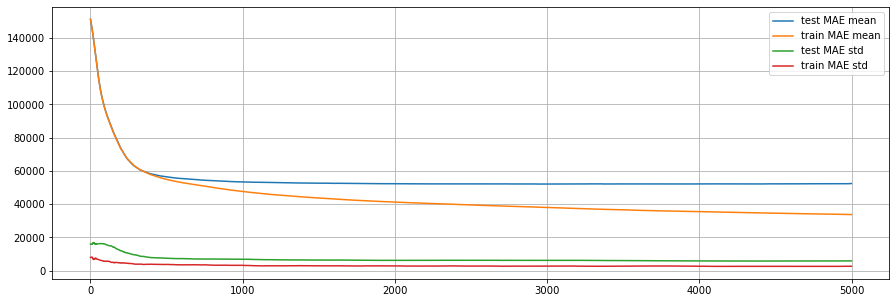

In [110]:
cv_res = grid_search_result['cv_results']

plt.figure(figsize=(15, 5))

plt.plot(cv_res['iterations'], cv_res['test-MAE-mean'], label='test MAE mean')
plt.plot(cv_res['iterations'], cv_res['train-MAE-mean'], label='train MAE mean')

plt.plot(cv_res['iterations'], cv_res['test-MAE-std'], label='test MAE std')
plt.plot(cv_res['iterations'], cv_res['train-MAE-std'], label='train MAE std')

plt.legend()
plt.grid()
plt.show()

In [112]:
%%time

X_train, X_test, y_train, y_test = datasets['A']

catboost = CatBoostRegressor(**grid_search_result['params'], loss_function='MAE', cat_features=categorical_features, 
                             random_state=111, verbose=0)

catboost.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, catboost.predict(X_train))
test_mae = mean_absolute_error(y_test, catboost.predict(X_test))

res = pd.DataFrame({'Dataset' : ['A'], 
                    'Parameters' : ['grid_search'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 3min 7s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,A,grid_search,4936.592246,46123.166535,41722.125271


In [113]:
df_catboost = pd.concat([df_catboost, res], ignore_index=True)
df_catboost

,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,B,default,1.520183,12549.359683,20241.625419
1,B,grid_search,1296.603924,6401.881716,15206.203190
2,C,default,1.349251,35147.434687,40415.019178
3,C,grid_search,887.521134,29547.976901,41243.672807
4,A,default,18.210191,49629.586784,43803.805067
5,A,grid_search,4936.592246,46123.166535,41722.125271


**Ваши выводы:**  
catboost показал очень хорошие результаты на датасете B c числовыми признаками. Подбор параметров позволил уменьшить ошибку на тесте на 5000, заняв при этом около 20 минут, поэтому можно считать его целесообразным с учетом затрат времени и малости ошибки.  
Обучение на датасете С дало "стандартную" ошибку около 40 тысяч, оптимизация параметров по сетке ее не улучшила (вероятно, сетка оказалось не удачной).  
Обучение на датасете А с категориальными признаками заняло намного больше времени, чем на датасете С (с dummy-кодированием), оптимизация параметров заняла неприличные полтора часа, так еще и не дала значительного уменьшения точности.  

Главный вывод: catboost показал очень хорошие результаты на числовых признаках, что "слегка" противоречит его названию (и назначению), а обучение на категориальных признаках занимает много времени (обучение с дефолтными параметрами для датасета А заняло 18 секунд!).  ЛУЧШЕ ИСПОЛЬЗОВАТЬ LIGHTGBM!

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

## Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.

### Задание 6 (кросс-проверка, 3 балла):
**Данные**: датасет с ценами поддержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи одного или нескольких графиков показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество, сравнение оптимизированных и неоптимизированных параметров.
2. По графикам сравните библиотеки, производительность и качество работы. Опишите ваши выводы ниже.

In [8]:
# Your great pictures and conclusions below!

**Ваши выводы:**

## Оптимизация параметров с hyperopt

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. И я почти уверен, что знаю вашу самую "любимую" часть всех этих заданий: оптимизация параметров. Она достаточно долгая, нудная, да еще и над сетками перебора нужно думать. Значит сейчас, когда вы поняли всю тяжесть этого процесса, мы можем узнать как относительно быстро и безболезненно нащупать оптимальные параметры!


[Эмоции выполняющего в этот момент.](https://disk.yandex.ru/i/qwkvBEFrWYoV9A)


Нашего спасителя зовут HyperOpt. На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интарвалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.

### Задание 7 (кросс-проверка, 4 балла):
**Данные**: датасет со стоимостью поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга (можете взять самую быструю)
2. Составить сетку перебора в hyperopt, включающую параметры n_estimators, max_depth и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как hp.choise, hp.qloguniform, hp.uniform и hp.quniform (можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. Реализуйте функцию, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект trials=Trials(), который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, оптимизируйте Вашу функцию. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. Выведите получившиеся параметры. Нарисуйте график, показывающий значение loss в ходе оптимизации. Посчитайте качество на тесте при использовании лучших параметров (возвращаются после использования fmin). Сделайте выводы по результату.

In [185]:
%%time

import warnings
warnings.filterwarnings("ignore")

trials = Trials()

def quality(params):
    model = LGBMRegressor(objective='mae', boosting_type='gbdt', n_jobs=-1, categorical_feature='auto', random_state=111)
    model.set_params(**params)
    
    X_train, y_train = datasets['A'][0], datasets['A'][2]
    
    cv_score = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    
    return -cv_score.mean()

grid = {
    'n_estimators' : scope.int(hp.qloguniform('n_estimators', low=np.log(100), high=np.log(6000), q=10)),
    'max_depth' : hp.choice(label='max_depth', options=np.arange(5, 14)), 
    'learning_rate' : hp.loguniform(label='learning_rate', low=np.log(10e-5), high=np.log(2))
}

start = time.time()
best = fmin(fn=quality,
            space=grid,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            verbose= 1,
            return_argmin=False)

learning_time = time.time() - start
# your super code for super graph

100%|████████████████████████████████████████████████| 100/100 [09:21<00:00,  5.62s/trial, best loss: 51166.5029221001]
Wall time: 9min 21s


In [186]:
best['n_estimators'] = int(best['n_estimators'])
best

{'learning_rate': 0.08814325106021954, 'max_depth': 11, 'n_estimators': 5090}

In [187]:
%%time

X_train, X_test, y_train, y_test = datasets['A']

lgbm = LGBMRegressor(**best, objective='mae', boosting_type='gbdt', n_jobs=-1, random_state=111)

lgbm.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, lgbm.predict(X_train))
test_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

res = pd.DataFrame({'Dataset' : ['A'], 
                    'Parameters' : ['hyperopt'], 
                    'Time' : [learning_time], 
                    'Train_MAE' : [train_mae], 
                    'Test_MAE' : [test_mae]
                   })
res

Wall time: 8.68 s


,Dataset,Parameters,Time,Train_MAE,Test_MAE
0,A,hyperopt,561.605244,43153.796108,39942.69093


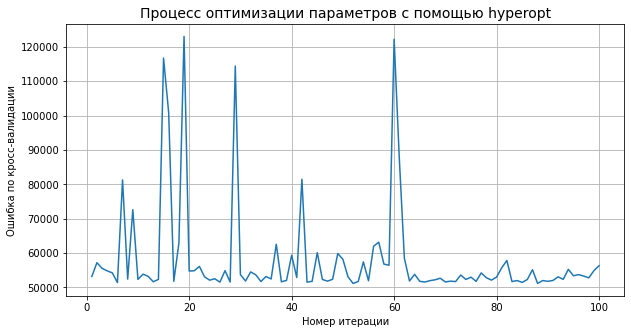

In [196]:
plt.figure(figsize=(10, 5))

num_iter = len(trials.results)
loss_values = list(map(lambda d: d['loss'], trials.results))

plt.plot(np.arange(1, 1 + num_iter), loss_values)

plt.title('Процесс оптимизации параметров с помощью hyperopt', fontsize=14)
plt.xlabel('Номер итерации')
plt.ylabel('Ошибка по кросс-валидации')

plt.grid()
plt.show()

**Ваши выводы:**  
В результате оптимизации получили ошибку на тесте около 39000 (почти столько же, сколько получили для LightGBM при переборе по сетке).  То есть существенного улучшения точности не получили.  
Оптимизация по сетке и через hyperopt заняло примерно одинаковое удельное время обучения модели (9 минут на 100 моделей у hyperoprt и чуть меньше 9 минут на 90 моделей при переборе по сетке). Вероятно, разница во времени работы не очень заметна, т.к. сетки примерно похожи. Возможно, разница была бы заметна, если бы в фиксированной сетке были заведомо неудачные параметры, требующие больших временных ресурсов (например, n_estimators=10000, а модель бы не давала существенного прироста точности)

## Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**Внимание!** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле awards_prediction.py, который вы можете найти в проверяющей системе.

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма
**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 1 до 3)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 1 до 3)

**actor_i_gender** - пол актера i (i от 1 до 3)

**actor_i_age** - возраст актера i (i от 1 до 3)

-----
**Внимание!** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

### Задание 8 (ML задание, 20 баллов):
**Данные**: датасет с ценами поддержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять любую библиотеку градиентного бустинга
2. Используя предложенный датасет, обучить регрессор для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. Загрузить решение и получить качество на закрытой выборке больше порогового значения


## Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!
